# Lab 9 - Long Short Term Memory (LSTM)

### Q1

7088
1.05 23.86
0 th iteration :  tensor(0.0450, grad_fn=<MseLossBackward0>)
50 th iteration :  tensor(0.0120, grad_fn=<MseLossBackward0>)
100 th iteration :  tensor(0.0061, grad_fn=<MseLossBackward0>)
150 th iteration :  tensor(0.0110, grad_fn=<MseLossBackward0>)
200 th iteration :  tensor(0.0121, grad_fn=<MseLossBackward0>)
250 th iteration :  tensor(0.0103, grad_fn=<MseLossBackward0>)
300 th iteration :  tensor(0.0136, grad_fn=<MseLossBackward0>)
350 th iteration :  tensor(0.0077, grad_fn=<MseLossBackward0>)
400 th iteration :  tensor(0.0113, grad_fn=<MseLossBackward0>)
450 th iteration :  tensor(0.0086, grad_fn=<MseLossBackward0>)
500 th iteration :  tensor(0.0110, grad_fn=<MseLossBackward0>)
550 th iteration :  tensor(0.0116, grad_fn=<MseLossBackward0>)
600 th iteration :  tensor(0.0093, grad_fn=<MseLossBackward0>)
650 th iteration :  tensor(0.0088, grad_fn=<MseLossBackward0>)
700 th iteration :  tensor(0.0092, grad_fn=<MseLossBackward0>)
750 th iteration :  tensor(0.0095, grad_fn

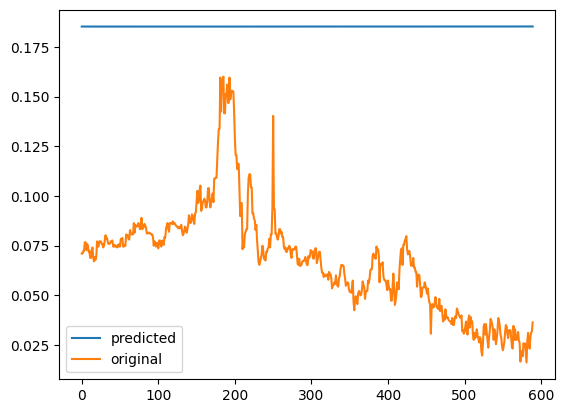

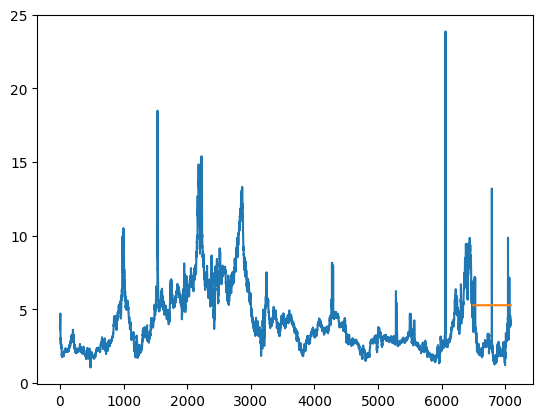

In [43]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

df = pd.read_csv("daily.csv")
df = df.dropna()
y = df['Price'].values
x = np.arange(1, len(y), 1)
print(len(y))

minm = y.min()
maxm = y.max()
print(minm, maxm)

y = (y - minm) / (maxm - minm)
Sequence_Length = 10
X = []
Y = []
for i in range(0, 5900):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[j + 1])

X = np.array(X)
Y = np.array(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y,
test_size=0.10, random_state=42, shuffle=False, stratify=None)

class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return self.len
    
dataset = NGTimeSeries(x_train,y_train)
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset,shuffle=True,batch_size=256)

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel,self).__init__()
        self.lstm = nn.LSTM(input_size=1,hidden_size=5,num_layers=1,batch_first=True)
        self.fc1 = nn.Linear(in_features=5,out_features=1)

    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output
    
model = LSTMModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1500

for i in range(epochs):
    for j, data in enumerate(train_loader):
        y_pred = model(data[:][0].view(-1, Sequence_Length,1)).reshape(-1)
        loss = criterion(y_pred, data[:][1])
        loss.backward()
        optimizer.step()
    if i % 50 == 0:
        print(i, "th iteration : ", loss)

test_set = NGTimeSeries(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,10,1)).view(-1)
plt.plot(test_pred.detach().numpy(),label='predicted')
plt.plot(test_set[:][1].view(-1),label='original')
plt.legend()
plt.show()

y = y * (maxm - minm) + minm
y_pred = test_pred.detach().numpy() * (maxm - minm) + minm
plt.plot(y)
plt.plot(range(len(y)-len(y_pred), len(y)), y_pred)
plt.show()

### Q2

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import glob
import unicodedata
import string
import random
import time
import zipfile
from io import BytesIO
from urllib.request import urlopen

ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

def download_and_extract():
    url = "https://download.pytorch.org/tutorial/data.zip"
    with urlopen(url) as response:
        with zipfile.ZipFile(BytesIO(response.read())) as z:
            z.extractall()

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if c in ALL_LETTERS
    )

category_lines = {}
categories = []

def read_data():
    global category_lines, categories
    for filename in glob.glob('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        categories.append(category)
        lines = open(filename, encoding='utf-8').read().strip().split("\n")
        category_lines[category] = [unicode_to_ascii(line) for line in lines]

def name_to_tensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for li, letter in enumerate(name):
        tensor[li][0][ALL_LETTERS.find(letter)] = 1
    return tensor

def category_to_tensor(category):
    return torch.tensor([categories.index(category)], dtype=torch.long)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        output = self.linear(lstm_out[-1])  
        return self.softmax(output)

def train(category_tensor, name_tensor):
    optimizer.zero_grad()
    output = rnn(name_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def predict(name):
    with torch.no_grad():
        tensor = name_to_tensor(name)
        output = rnn(tensor)
        top_v, top_i = output.topk(1)
        return categories[top_i[0].item()]

download_and_extract()
read_data()
N_CATEGORIES = len(categories)
HIDDEN_SIZE = 128
rnn = LSTM(N_LETTERS, HIDDEN_SIZE, N_CATEGORIES)
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005)

n_iters = 100000
for iter in range(n_iters):
    category = random.choice(categories)
    name = random.choice(category_lines[category])
    category_tensor = category_to_tensor(category)
    name_tensor = name_to_tensor(name)
    output, loss = train(category_tensor, name_tensor)
    if iter % 5000 == 0:
        print(f'Iteration {iter}, Loss: {loss}')

# Test prediction
print(f'The predicted language is: {predict("Schmidt")}')  # Example prediction

Iteration 0, Loss: 2.9359755516052246
Iteration 5000, Loss: 2.7872231006622314
Iteration 10000, Loss: 2.953200340270996
Iteration 15000, Loss: 2.6750102043151855
Iteration 20000, Loss: 2.572657823562622
Iteration 25000, Loss: 2.6213479042053223
Iteration 30000, Loss: 2.7315258979797363
Iteration 35000, Loss: 1.9518945217132568
Iteration 40000, Loss: 0.137053444981575
Iteration 45000, Loss: 2.8809239864349365
Iteration 50000, Loss: 2.4510741233825684
Iteration 55000, Loss: 1.431969404220581
Iteration 60000, Loss: 1.0498429536819458
Iteration 65000, Loss: 3.1437299251556396
Iteration 70000, Loss: 2.6723668575286865
Iteration 75000, Loss: 3.3287205696105957
Iteration 80000, Loss: 1.961442232131958
Iteration 85000, Loss: 0.6845051646232605
Iteration 90000, Loss: 0.3036820888519287
Iteration 95000, Loss: 1.6601396799087524
The predicted language is: English


### Q3

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

text = "hello world! this is a simple character prediction model using LSTM. let's see how it performs."

all_characters = sorted(list(set(text)))
n_characters = len(all_characters)
char_to_index = {char: idx for idx, char in enumerate(all_characters)}
index_to_char = {idx: char for idx, char in enumerate(all_characters)}

n_hidden = 128
n_layers = 2
learning_rate = 0.005
sequence_length = 10
n_iters = 1000

class LSTMCharacterPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMCharacterPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :]) 
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(n_layers, batch_size, self.hidden_size),
                torch.zeros(n_layers, batch_size, self.hidden_size))

def prepare_sequences(text, seq_length):
    inputs = []
    targets = []
    for i in range(len(text) - seq_length):
        seq = text[i:i + seq_length]
        target = text[i + seq_length]
        inputs.append([char_to_index[char] for char in seq])
        targets.append(char_to_index[target])
    return np.array(inputs), np.array(targets)

X, y = prepare_sequences(text, sequence_length)

X_tensor = torch.zeros(X.shape[0], sequence_length, n_characters)
y_tensor = torch.tensor(y, dtype=torch.long)

for i in range(X.shape[0]):
    for j in range(sequence_length):
        X_tensor[i][j][X[i][j]] = 1 

model = LSTMCharacterPredictor(n_characters, n_hidden, n_characters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for iter in range(n_iters):
    hidden = model.init_hidden(X_tensor.size(0))
    optimizer.zero_grad()

    output, hidden = model(X_tensor, hidden)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
        print(f'Iteration {iter}, Loss: {loss.item()}')

def predict_next_char(model, input_seq, n_predict=1):
    model.eval()
    input_seq = [char_to_index[char] for char in input_seq]
    input_tensor = torch.zeros(1, sequence_length, n_characters)
    
    for i in range(sequence_length):
        input_tensor[0][i][input_seq[i]] = 1 

    hidden = model.init_hidden(1)
    predicted_chars = []

    for _ in range(n_predict):
        output, hidden = model(input_tensor, hidden)
        top_char_idx = torch.argmax(output).item()
        predicted_chars.append(index_to_char[top_char_idx])
        
        input_seq = input_seq[1:] + [top_char_idx]
        input_tensor = torch.zeros(1, sequence_length, n_characters)
        for i in range(sequence_length):
            input_tensor[0][i][input_seq[i]] = 1  

    return ''.join(predicted_chars)

input_sequence = "hello worl"  
predicted_char = predict_next_char(model, input_sequence, n_predict=5)
print(f'Input sequence: "{input_sequence}"')
print(f'Predicted next characters: "{predicted_char[0]}"')

Iteration 0, Loss: 3.2387778759002686
Iteration 100, Loss: 0.008505088277161121
Iteration 200, Loss: 0.002005469985306263
Iteration 300, Loss: 0.0010242732241749763
Iteration 400, Loss: 0.0006441625882871449
Iteration 500, Loss: 0.00044717328273691237
Iteration 600, Loss: 0.0003306714352220297
Iteration 700, Loss: 0.0002552295627538115
Iteration 800, Loss: 0.00020375433086883277
Iteration 900, Loss: 0.00016648555174469948
Input sequence: "hello worl"
Predicted next characters: "d"


### Q4

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

data = torch.arange(1, 21, dtype=torch.float32)

seq_length = 5
batch_size = 4
input_size = 1

inputs = data.view(batch_size, seq_length, input_size)

hidden_size = 1
num_layers = 1
lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

for name, param in lstm.named_parameters():
    nn.init.constant_(param, 1.0)

h0 = torch.zeros(num_layers, batch_size, hidden_size)
c0 = torch.zeros(num_layers, batch_size, hidden_size)

output, (hn, cn) = lstm(inputs, (h0, c0))

print("Input:")
print(inputs.squeeze(-1))
print("\nLSTM Output (last hidden state for each timestep):")
print(output.squeeze(-1))
print("\nFinal Hidden State hn:")
print(hn.squeeze())
print("\nFinal Cell State cn:")
print(cn.squeeze())

Input:
tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10.],
        [11., 12., 13., 14., 15.],
        [16., 17., 18., 19., 20.]])

LSTM Output (last hidden state for each timestep):
tensor([[0.7038, 0.9501, 0.9916, 0.9983, 0.9996],
        [0.7612, 0.9639, 0.9950, 0.9993, 0.9999],
        [0.7616, 0.9640, 0.9951, 0.9993, 0.9999],
        [0.7616, 0.9640, 0.9951, 0.9993, 0.9999]], grad_fn=<SqueezeBackward1>)

Final Hidden State hn:
tensor([0.9996, 0.9999, 0.9999, 0.9999], grad_fn=<SqueezeBackward0>)

Final Cell State cn:
tensor([4.9173, 4.9995, 5.0000, 5.0000], grad_fn=<SqueezeBackward0>)
